# Subgrid tendency analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from modules import tools


In [2]:
base_path = '/srv/ccrc/AtmSS/z5310829/honours_project/'
fig_path = base_path + 'figures/thesis/04_tendencies/'
data_path = base_path + 'data/training/'


In [3]:
coarse_t = xr.open_mfdataset(
    data_path + '256x64_from_2048x256_diffused_t/*.nc')
# true_coarse_dt = xr.open_mfdataset()
pred_coarse_dt = xr.open_mfdataset(
    data_path + '256x64_from_2048x256_diffused_tplusdt/*.nc')

coarse_t = coarse_t.isel(t=(coarse_t.t < 299))
# true_coarse_dt = true_coarse_dt.isel(t=(true_coarse_dt.t < 299))
pred_coarse_dt = pred_coarse_dt.isel(t=(pred_coarse_dt.t < 299))

true_coarse_tend = xr.open_dataset(
    data_path + '2048x256_tend_256x64/2048x256_tend_256x64.nc')
# true_coarse_tend = tools.tendency(coarse_t, true_coarse_dt)
pred_coarse_tend = tools.tendency(coarse_t, pred_coarse_dt)
subgrid_tend = true_coarse_tend - pred_coarse_tend


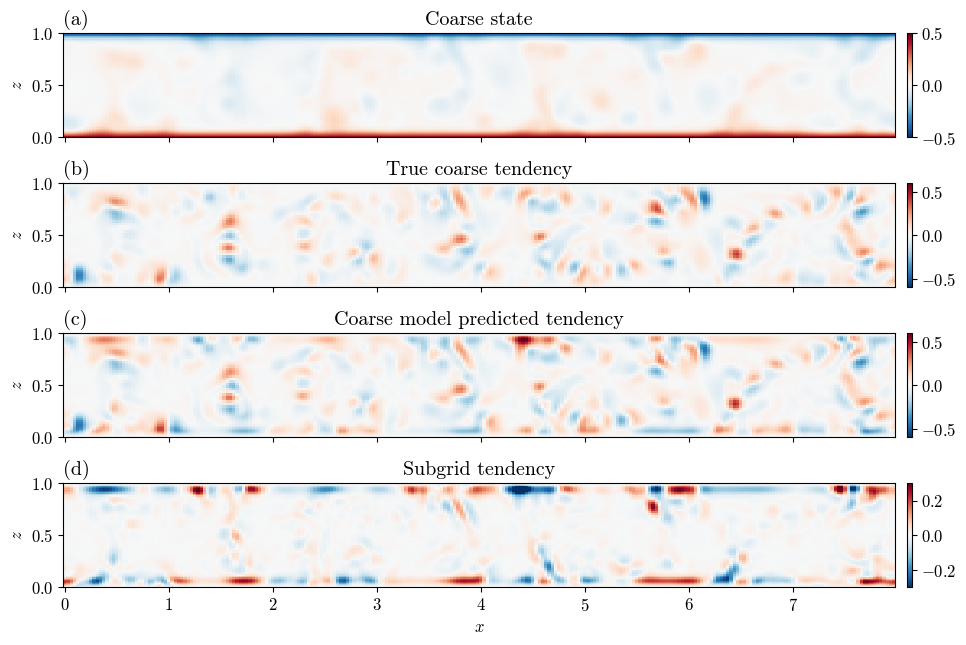

In [4]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(12, 6.5))

mesh = axes[0].pcolormesh(
    coarse_t.x, coarse_t.z, coarse_t.theta.isel(t=-1).T,
    vmin=-1/2, vmax=1/2, cmap='RdBu_r'
)
axes[0].set(aspect='equal', ylabel='$z$', title='Coarse state')
fig.colorbar(mesh, ax=axes[0], pad=0.01)

mesh = axes[1].pcolormesh(
    true_coarse_tend.x, true_coarse_tend.z,
    true_coarse_tend.theta.isel(t=-1).T,
    vmin=-0.6, vmax=0.6, cmap='RdBu_r'
)
axes[1].set(aspect='equal', ylabel='$z$', title='True coarse tendency')
fig.colorbar(mesh, ax=axes[1], pad=0.01)

mesh = axes[2].pcolormesh(
    pred_coarse_tend.x, pred_coarse_tend.z,
    pred_coarse_tend.theta.isel(t=-1).T,
    vmin=-0.6, vmax=0.6, cmap='RdBu_r'
)
axes[2].set(
    aspect='equal', ylabel='$z$', title='Coarse model predicted tendency',
)
fig.colorbar(mesh, ax=axes[2], pad=0.01)

mesh = axes[3].pcolormesh(
    subgrid_tend.x, subgrid_tend.z, subgrid_tend.theta.isel(t=-1).T,
    vmin=-0.3, vmax=0.3, cmap='RdBu_r'
)
axes[3].set(
    aspect='equal', ylabel='$z$', xlabel='$x$', title='Subgrid tendency',
)
fig.colorbar(mesh, ax=axes[3], pad=0.01)

tools.label_subplots(axes)
fig.tight_layout()
